# Lab 4-: Mixture Models and Model order selection 

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts **(this notebook will be updated with instructions for the second part and the deadline)**.

You have to send the filled notebook named **"L4__familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com and put **"AML-L4- "** in the subject. 

We begin with the standard imports:

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [134]:
class my_GMM():
    
    def __init__(self, k, tol=1e-2, itermax=25):
        '''
        Parameters:
        k: integer
            number of components
        tol: float
            convergence tolerance
       
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.tol_ = tol
        self.itermax_ = itermax
        
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
        self.history = {}
    
    def gauss_pdf(self, x_i, mu, Sigma):
        """
        Computes the PDF of a Gaussian distribution of parameters Sigma and mu,
        evaluated in point x_i
        
        Parameters:
        -----------
        x_i: (p, ) np.array
            Point of evaluation
        
        mu: (p, ) np.array
            Estimator of the mean
            
        Sigma: (p, p) np.array
            Variance matrix estimator
        
        Returns:
        -----
        Evaluation of the PDF
        """
        C = 1/(np.sqrt(2 * np.pi * np.linalg.det(Sigma)))
        Sigma_inv = np.linalg.inv(Sigma)
        dev = (x_i - mu).reshape(-1, 1)
        #print(C, Sigma, np.linalg.det(Sigma))
        exp = np.exp(-0.5 * dev.T @ Sigma_inv @ dev)
        return C * exp
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """    
        self.has_converged = False
        
        # Initialize parameters estimators
        self.alpha_, self.mu_, self.Sigma_ = self.init_params(X, self.k_)
        
        self.history = {"cpm": [], "alpha": [], "mu": [], "Sigma": []}
        
        itr = 0
        while not self.has_converged and itr < self.itermax_:
            itr += 1
            # E-step: compute conditional probability matrix
            self.cond_prob_ = self.compute_proba(X=X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_)
            
            self.history["cpm"].append(self.cond_prob_)
            self.history["alpha"].append(self.alpha_)
            self.history["mu"].append(self.mu_)
            self.history["Sigma"].append(self.Sigma_)
            
            # M-step: update parameters estimators
            new_alpha = self.update_alpha(cpm=self.cond_prob_)
            new_mu = self.update_mu(X=X, cpm=self.cond_prob_, alpha=new_alpha)
            new_Sigma = self.update_Sigma(X=X, cpm=self.cond_prob_, alpha=new_alpha, mu=new_mu)
            
            old_params = (self.alpha_, self.mu_, self.Sigma_)
            new_params = (new_alpha, new_mu, new_Sigma)
            
            self.has_converged = self.evaluate_convergence(X, old_params=old_params, new_params=new_params)
            
            self.alpha_ = new_alpha
            self.mu_ = new_mu
            self.Sigma_ = new_Sigma
        
        self.labels_ = self.predict(X)
        return self
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """ 
        n= X.shape[0]
        labels = np.argmax(self.cond_prob_, axis=1)
        return labels
    
    def evaluate_convergence(self, X, old_params, new_params):
        """Returns wether the algorithm has converged
        """
        return abs(self.log_likelihood(X, *old_params) - self.log_likelihood(X, *new_params)) <= self.tol_
        
    def compute_proba(self, X, alpha, mu, Sigma):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n = X.shape[0]
        k = self.k_

        prob_matrix = np.zeros(shape=(n, k))

        for i in range(n):
            joint_law = 1e-4
            x_i = X[i]
            for j in range(k):
                prob_matrix[i, j] = alpha[j] * self.gauss_pdf(x_i=x_i, mu=mu[j], Sigma=Sigma[j])
                joint_law += prob_matrix[i, j]
            prob_matrix[i, :] /= joint_law
        
        return prob_matrix
    
    def init_params(self, X, K):
        """Initialize parameters estimators
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        K: int
            Number of classes / clusters
        
        Returns:
        -----
        ((k,) np.array, (k, p) np.array, (k, p, p) np.array) tuple
            Tuple of 3 np.arrays: (alpha0, mu0, Sigma0)
        """        
        n = X.shape[0]
        p = X.shape[1]
        
        from sklearn.cluster import KMeans
        k_means = KMeans(n_clusters=K).fit(X)
        X_labels = k_means.labels_
        
        mu0 = k_means.cluster_centers_
        Sigma0 = []
        alpha0 = []
        
        for k, count in zip(*np.unique(X_labels, return_counts=True)):
            X_k = np.array([X[i] for i in range(n) if X_labels[i] == k])
            Sigma0.append(np.cov(X_k.T) + 1e-3 * np.eye(p))
            alpha0.append(count/n)
        Sigma0 = np.array(Sigma0)
        alpha0 = np.array(alpha0)
        
        return (alpha0, mu0, Sigma0)
    
    def update_alpha(self, cpm):
        """Returns the updated version of alpha (cluster proportion estimators)
        
        Parameters:
        -----------
        cpm: (n, k) np.array
            Conditional probability matrix

        Returns:
        -----
        (k,) np.array
            The new estimators for cluster proportion
        """
        n = cpm.shape[0]
        k = cpm.shape[1]

        new_alpha = np.zeros((k,))
        for j in range(k):
            new_alpha[j] = np.sum(cpm[:, j]) / n
        return new_alpha
    
    def update_mu(self, X, cpm, alpha):
        """Returns the updated version of mu (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        Returns:
        -----
        (k, p) np.array
            The new estimators for clusters' means
        """
        n = cpm.shape[0]
        k = cpm.shape[1]   
        p = X.shape[1]

        new_mu = np.zeros(shape=(k, p))

        for j in range(k):
            for i in range(n):
                new_mu[j] += X[i] * cpm[i, j]
            new_mu[j] /= (alpha[j] * n)

        return new_mu

    def update_Sigma(self, X, cpm, alpha, mu):
        """Returns the updated version of Sigma (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
        
        Returns:
        -----
        (k, p, p) np.array
            The new estimators for clusters' variances
        """
        n = cpm.shape[0]
        k = cpm.shape[1]
        p = X.shape[1]
        
        new_Sigma = np.zeros(shape=(k, p, p))
        
        for j in range(k):
            for i in range(n):
                deviation = (X[i] - mu[j]).reshape(-1, 1)
                new_Sigma[j] += deviation@deviation.T * cpm[i, j]
            new_Sigma[j] /= (alpha[j] * n)
        
        return new_Sigma
    
    def log_likelihood(self, X, alpha, mu, Sigma):
        """Returns whether the algorithm has converged
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
            
        Sigma: (k, p, p) np.array
            Current estimators for clusters' variances
        
        Returns:
        -----
        float
            log-likelihood for the given parameters
        """
        l = 0
        n = X.shape[0]
        k = alpha.shape[0]
        
        for i in range(n):
            x_i = X[i]
            inner = 0
            for j in range(k):
                inner += alpha[j] * self.gauss_pdf(x_i=x_i, mu=mu[j], Sigma=Sigma[j])
            l += np.log(inner)
        return l

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

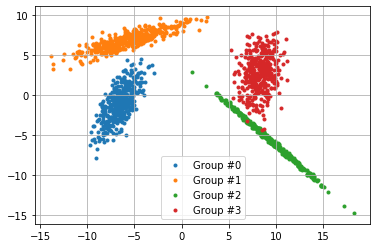

In [135]:
X = []

for _ in range(4):
    mu = np.random.uniform(-10,10, (2,))
    sigma = np.random.uniform(-3,3, (2,2))
    sigma = sigma.T@sigma
    pts = []
    for _ in range(400):
        pts.append(np.random.multivariate_normal(mean=mu, cov=sigma))
    X.append(np.array(pts))

for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], marker='.', label="Group #{}".format(i))
plt.legend()
plt.grid()
plt.show()

In [138]:
data = np.concatenate(X)

In [139]:
gmm = my_GMM(k=4)
gmm.fit(data)
print("Has converged:", gmm.has_converged)

Has converged: [[ True]]


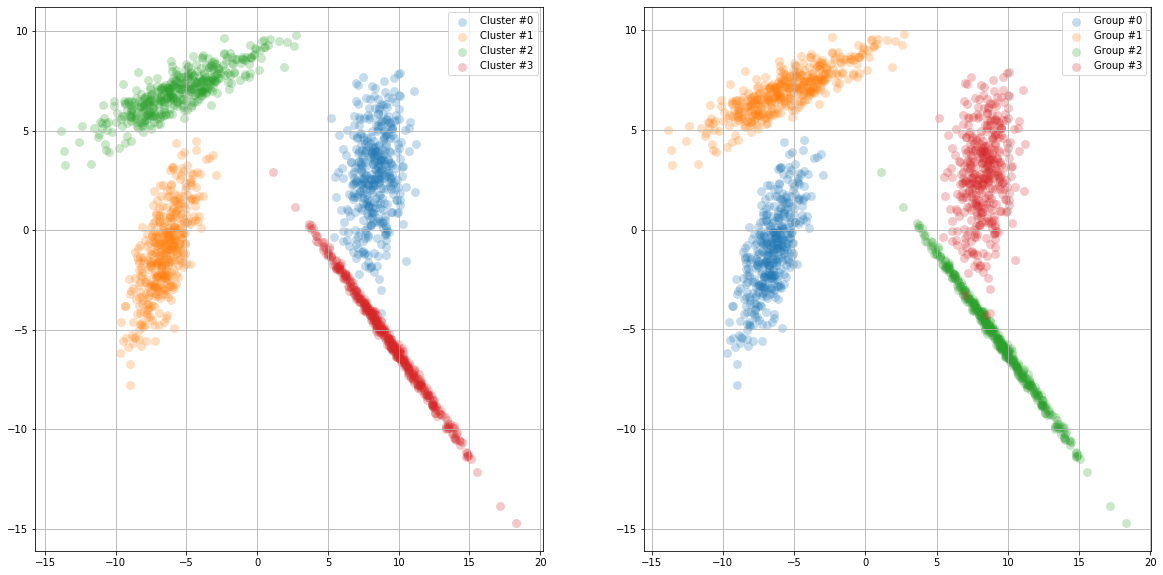

In [140]:
plt.figure(figsize=(20,10))

plt.subplot(121)
for label in np.unique(gmm.labels_):
    data_i = np.array([data[j] for j in range(data.shape[0]) if gmm.labels_[j] == label])
    plt.scatter(data_i.T[0], data_i.T[1], label="Cluster #{}".format(label), **plot_kwds)
plt.legend()
plt.grid()

plt.subplot(122)
for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], label="Group #{}".format(i), **plot_kwds)
plt.legend()
plt.grid()
plt.show()

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
To be updated